# DI 725 Project Phase 2/3 - Ali Yiğit Başaran - 2231355 
#### Dataset Preparation - Modeling - Train, Validation Loop - Test & Log Metrics 

In [ ]:
# Setup and Imports
# ! pip install -U -q transformers accelerate datasets
import os
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
import re
import numpy as np
from matplotlib import pyplot as plt

from transformers import AutoProcessor, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
import pandas as pd
import os
from PIL import Image

# Load the captions CSV file
df = pd.read_csv('./RISCM/captions.csv')


# Decrease the number of the captions
#### Per each image the best caption is taken such that which caption has the highest average of bleu, meteor and rouge scores

In [ ]:
import pandas as pd
from tqdm import tqdm
import evaluate

caption_cols = ['caption_1', 'caption_2', 'caption_3', 'caption_4', 'caption_5']

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

best_captions = []

# Choose best caption for each image according to the average of metrics
for _, row in tqdm(df.iterrows(), total=len(df), desc="Filtering captions"):
    # Caption'ları topla ve temizle
    captions = [row[col].strip() for col in caption_cols if isinstance(row[col], str) and row[col].strip()]
    unique_captions = list(set(captions))

    if not unique_captions:
        selected = ""
    elif len(unique_captions) == 1:
        selected = unique_captions[0]
    else:
        scores = []
        for i, cand in enumerate(unique_captions):
            refs = [c for j, c in enumerate(unique_captions) if j != i]
            try:
                rouge_score = rouge.compute(predictions=[cand], references=[refs])['rougeL']
                bleu_score = bleu.compute(predictions=[cand], references=[refs])['bleu']
                meteor_score = meteor.compute(predictions=[cand], references=refs)['meteor']
                avg_score = (rouge_score + bleu_score + meteor_score) / 3
            except Exception:
                avg_score = 0
            scores.append(avg_score)

        selected = unique_captions[scores.index(max(scores))]

    best_captions.append({
        'source': row['source'],
        'split': row['split'],
        'image': row['image'],
        'filtered_caption': selected 
    })

# Save results
filtered_df = pd.DataFrame(best_captions)
filtered_df.to_csv('./RISCM/filtered_captions_fixed.csv', index=False)
print("✅ Best captions saved to filtered_captions.csv")


# Use the filtered captions for training and eval

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv("./RISCM/filtered_captions_fixed.csv")
display(df.head())


,source,split,image,filtered_caption
0,NWPU,test,NWPU_31430.jpg,A plane is parked on the runway next to the gr...
1,NWPU,test,NWPU_31431.jpg,Four planes of different sizes were on the mar...
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...
3,NWPU,test,NWPU_31433.jpg,Two planes of different sizes are neatly parke...
4,NWPU,test,NWPU_31434.jpg,Two aircraft were parked at the departure gates .


# Modeling and LoRA Param Configs

In [ ]:
import torch
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
from peft import get_peft_model, LoraConfig, TaskType

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-pt-224"
base_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
processor = PaliGemmaProcessor.from_pretrained(model_id)

# The training and evaluation is done for Lora-1 and Lora-2 Hyperparams

# Lora-1 Hyperparams
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.2,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj"]
)

# Lora-2 Hyperparams
# lora_config = LoraConfig(
#     r=2,
#     lora_alpha=4,
#     lora_dropout=0.1,
#     bias="none",
#     task_type=TaskType.CAUSAL_LM,
#     target_modules=["q_proj", "o_proj"]
# )

model = get_peft_model(base_model, lora_config)

# Total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Freezing everything but the attention layers

for name, param in model.named_parameters():
    if "attn" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
# Trainable attention layer parameters
attn_params = sum(
    p.numel() for name, p in model.named_parameters()
    if p.requires_grad and "attn" in name
)

print(f"Total trainable parameters: {total_params}")
print(f"Trainable attention parameters: {attn_params}")


2025-05-14 09:42:25.093135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747215745.116327     137 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747215745.123339     137 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
batch_size = 1
learning_rate = 1e-5

# Dataset Preaparation and Data Loading

In [ ]:
import pandas as pd
from datasets import Dataset

# Split data according to train-val-test and remove unused columns (such split and source after preparing datasets)
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df = df[df["split"] == "val"].reset_index(drop=True)
test_df = df[df["split"] == "test"].reset_index(drop=True)
train_df = train_df.drop(columns=["source", "split"])
val_df = val_df.drop(columns=["source", "split"])
test_df = test_df.drop(columns=["source", "split"])
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
from PIL import Image

image_dir = "./RISCM/resized"

# Create Data Loader
def collate_train_fn(examples):
    images = [Image.open(os.path.join(image_dir, ex["image"])).convert("RGB") for ex in examples]
    prompt = ["caption the image" for _ in examples]
    suffix = [example["filtered_caption"] for example in examples]

    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs


def collate_test_fn(examples):
    images = [Image.open(os.path.join(image_dir, ex["image"])).convert("RGB") for ex in examples]

    prompt = ["caption the image" for _ in examples]

    inputs = processor(
        images=images,
        text=prompt,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs


train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=False,
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_test_fn,
    batch_size=batch_size,
    shuffle=False,
)

# Wandb Configs

In [ ]:
import wandb
import os

# Set W&B API key in the environment
os.environ["WANDB_API_KEY"] = "1640c7993fb7d40efc5ce820586098b3f8a569f4"

# Login to wandb
wandb.login()

# Choose the run name according to the lora param configuration
wandb.init(reinit=True, project="DI725_Project", name="paligemma-lora1-ft")
# wandb.init(reinit=True, project="DI725_Project", name="paligemma-lora2-ft")

model = model.to(dtype=torch.bfloat16, device=device)

# Train and Validation Loop

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from collections import deque
from transformers import get_linear_schedule_with_warmup

NUMBER_OF_TRAIN_LOSS_LOG = 100
NUM_EPOCHS = 3

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay = 1e-3)
num_training_steps = len(train_dataloader) * NUM_EPOCHS
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

model.train()
loss_window = deque(maxlen=NUMBER_OF_TRAIN_LOSS_LOG)

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}")
    # Training Loop
    for idx, batch in progress_bar:
        # batch = {k: v.to(torch.bfloat16).to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()


        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        loss_window.append(loss.item())

        # print(f"Epoch: {epoch+1} Iter: {idx} Train Loss: {loss.item():.4f}")

        if idx % NUMBER_OF_TRAIN_LOSS_LOG == 0 and len(loss_window) == NUMBER_OF_TRAIN_LOSS_LOG:
            avg_last_runs = sum(loss_window) / NUMBER_OF_TRAIN_LOSS_LOG
            wandb.log({
                "train_loss": avg_last_runs,
                "step": epoch * len(train_dataloader) + idx,
                "learning_rate": scheduler.get_last_lr()[0]
            })
    # Validate the model per end of epochs
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_outputs = model(**val_batch)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    scheduler.step(avg_val_loss)
    wandb.log({
        "val_loss": avg_val_loss,
        "epoch": epoch + 1,
    })
    for param_group in optimizer.param_groups:
      print(f"Epoch {epoch+1} | Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f} Learning Rate: {param_group['lr']:.6f}\n")

    model.train()


# Test the model on the test set and log bleu, rouge and meteor metrics
#### This part is run for 3 times:
* Baseline
* Fine Tuned with Lora-1 Configuraton
* Fine Tuned with Lora-2 Configuraton

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import torch
import wandb
from evaluate import load

# For testing baseline model uncomment below

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_id = "google/paligemma-3b-pt-224"
# model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
# processor = PaliGemmaProcessor.from_pretrained(model_id)

# Load evaluation metrics
bleu = load("bleu")
rouge = load("rouge")
meteor = load("meteor")

# Set model to eval mode
model.eval()
predictions = []
references = []

# === Helper Function ===
def read_image(path):
    image = Image.open(path).convert("RGB")
    image = np.array(image)
    if image.shape[-1] == 4:
        image = image[:, :, :3]
    return image
# Evaluate only on test_df
for i, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
    image_path = os.path.join("./RISCM/resized", row["image"])
    try:
        image = read_image(image_path)
    except Exception as e:
        print(f"❌ Skipped {image_path}: {e}")
        continue

    input_text = "caption the image\n"
    inputs = processor(
        text=input_text,
        images=image,
        do_convert_rgb=True,
        padding="longest",
        return_tensors="pt"
    ).to(base_model.device)

    inputs = inputs.to(dtype=base_model.dtype)

    with torch.no_grad():
        output = base_model.generate(**inputs, max_new_tokens=64)

    decoded = processor.decode(output[0], skip_special_tokens=True)
    cleaned = decoded.lower().replace("caption the image", "").strip(" :.-").strip()

    predictions.append(cleaned)
    references.append(row["filtered_caption"])
    
# Compute final scores
bleu_refs = [[ref] for ref in references]
bleu_score = bleu.compute(predictions=predictions, references=bleu_refs)["bleu"]
rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]
meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]

# Log to wandb
wandb.log({
    "test_bleu": bleu_score,
    "test_rougeL": rouge_score,
    "test_meteor": meteor_score
})


# Save Results From wandb

In [6]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import os

In [7]:
# Set W&B API key in the environment
os.environ["WANDB_API_KEY"] = "1640c7993fb7d40efc5ce820586098b3f8a569f4"

# Login to wandb
wandb.login()

wandb: Currently logged in as: aliyigitbasaran (aliyigitbasaran-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
api = wandb.Api()

entity = "aliyigitbasaran-"  
project = "DI725_Project"   

# Run IDs
run_ids = {
    "Baseline": "4yjdxh51",
    "LoRA-1": "hskjwi74",
    "LoRA-2": "e27eg465"
}

# Fetch runs
runs = {name: api.run(f"{entity}/{project}/{run_id}") for name, run_id in run_ids.items()}



### Test metric plotting

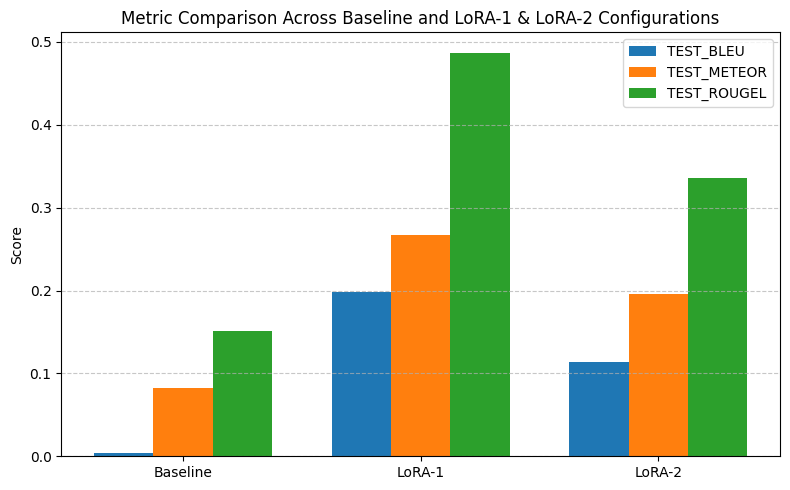

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def extract_history(run, metrics):
    history = run.history(samples=10000)  # increase if needed
    return history[metrics]

# Example: Metrics to extract
metrics_to_plot = ["test_bleu", "test_meteor", "test_rougeL"]

# Create a dictionary of DataFrames
history_dfs = {
    name: extract_history(run, metrics_to_plot) for name, run in runs.items()
}


# Metrics and run names
metrics = ["test_bleu", "test_meteor", "test_rougeL"]
run_names = list(history_dfs.keys())

# Collect values per run per metric
metric_values = []
for metric in metrics:
    values = []
    for run in run_names:
        df = history_dfs[run]
        val = df[metric].dropna().values[0] if metric in df.columns else 0
        values.append(val)
    metric_values.append(values)  # shape: [metrics][runs]

# Convert to NumPy array for easy plotting
metric_values = np.array(metric_values)

# Bar settings
x = np.arange(len(run_names))
width = 0.25  # width of each bar

# Plot
plt.figure(figsize=(8, 5))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, metric_values[i], width, label=metric.upper())

plt.xticks(x + width, run_names)
plt.ylabel("Score")
plt.title("Metric Comparison Across Baseline and LoRA-1 & LoRA-2 Configurations")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
os.makedirs("../figures", exist_ok=True)
plt.savefig("../figures/test_metric_comparison.png", dpi=300)
plt.show()




### Training Losses PLotting 

In [10]:
# Focus only on LoRA runs
lora_runs = {
    name: run for name, run in runs.items() if name.lower().startswith("lora")
}
def fetch_train_loss(run):
    history = run.history(samples=10000)  # or increase if needed
    if "train_loss" in history.columns:
        return history[["train_loss"]].dropna().reset_index(drop=True)
    else:
        return pd.DataFrame()

# Get train loss history for each LoRA run
train_loss_histories = {
    name: fetch_train_loss(run) for name, run in lora_runs.items()
}


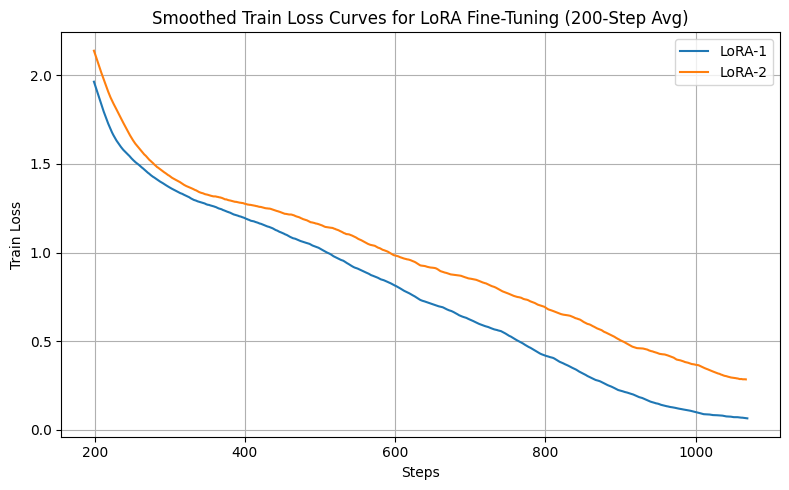

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for name, df in train_loss_histories.items():
    if not df.empty:
        # Apply 200-step moving average smoothing
        smoothed_loss = df["train_loss"].rolling(window=200).mean()
        plt.plot(smoothed_loss, label=f"{name}")

plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.title("Smoothed Train Loss Curves for LoRA Fine-Tuning (200-Step Avg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
os.makedirs("../figures", exist_ok=True)
plt.savefig("../figures/train_losses_lora1_lora2.png", dpi=300)
plt.show()


In [24]:
def fetch_val_loss(run):
    history = run.history(samples=200000)
    if "val_loss" in history.columns:
        return history[["val_loss"]].dropna().reset_index(drop=True)
    else:
        return pd.DataFrame()

# Get eval loss history for each LoRA run
eval_loss_histories = {
    name: fetch_val_loss(run) for name, run in lora_runs.items()
}


In [ ]:
import matplotlib.pyplot as plt

# Uniform step positions for all runs
step_positions = [400, 600, 800]

plt.figure(figsize=(8, 5))

for name, df in eval_loss_histories.items():
    if not df.empty and "val_loss" in df.columns:
        val_losses = df["val_loss"].dropna().values[:3]
        if len(val_losses) == 0:
            continue
        # elif len(val_losses < 3):
        #     val_losses.appe
        # Extend step positions if fewer than 3 values
        steps = step_positions[:len(val_losses)]
        plt.plot(steps, val_losses, marker='o', label=name)

plt.xlabel("Steps")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for LoRA Fine-Tuning (Forcibly Mapped to Steps 400–800)")
plt.xlim(300, 900)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'appe'

<Figure size 800x500 with 0 Axes>

In [17]:
for name, df in eval_loss_histories.items():
    if not df.empty and "val_loss" in df.columns:
        print(f"\n{name} - Validation Losses:")
        for i, val in df["val_loss"].dropna().items():
            print(f"  Step: {i}, val_loss: {val:.4f}")



LoRA-1 - Validation Losses:
  Step: 0, val_loss: 0.7802
  Step: 1, val_loss: 0.2153
